In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io

url_x = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy'
url_y = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [2]:
from numba import jit

In [3]:
def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return vec + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=vec.shape)

In [4]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [5]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


# Clipping and Gradient definition

In [331]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [332]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    clipped_grads = L2_clip_array(gradients, C)
    return np.sum(clipped_grads, axis = 0)

In [333]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

In [334]:
def dp_gradient_descent(iterations, alpha, epsilon):
    eps_i = epsilon/iterations
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 5
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy
    for i in range(iterations):
        grad_sum        = vgradient(theta, X_train, y_train, clipping_param)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, clipping_param, 1, 1e-5)
        noisy_avg_grad  = noisy_grad_sum / num_examples
        theta           = theta - noisy_avg_grad

    return theta

# Baseline (gradient clipping DP-SGD)

In [340]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [358]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grad_sum        = vgradient(theta, xs, ys, clipping_param)
            noisy_grad_sum  = gaussian_mech_zCDP_vec(grad_sum, clipping_param, rho_i)
            noisy_avg_grad  = noisy_grad_sum / BATCH_SIZE
            theta           = theta - noisy_avg_grad

    return theta

In [359]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [360]:
get_eps(.01, 500, 1e-5)

Total epsilon = 0.033071994919780016, delta = 1e-05


0.033071994919780016

In [364]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho * np.log(1/delta))
zcdp_eps(0.001, 1e-5)

0.21559660262893474

In [367]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7574524546660768
std: 0.013548767824902396


# Smooth Sensitivity Trimmed Mean

In [57]:
def get_with_default(values, indexes, lower, upper):
    return np.concatenate(([lower], values, [upper]))[
        np.maximum(np.minimum(indexes, len(values)), -1) + 1]

In [58]:
def build_indices(n, m, k_range):
    lhs_indices = []
    rhs_indices = []
    for k in range(0, k_range):
        lhs_indices.append(np.array([n-m+1+k-l for l in range(0, k+2)]))
        rhs_indices.append(np.array([m+1-l for l in range(0, k+2)]))
    return (lhs_indices, rhs_indices)

In [59]:
n = 20
m = 2
a = 0
b = 10
lhs_indices, rhs_indices = build_indices(n, m, 128)

In [449]:
def compute_sens(xs, t, n, m, a, b, lhs_indices, rhs_indices):
    # calculate the smooth sensitivity
    scaled_sensitivity_at_distances = []

    #for k in range(0, n+1):
    for k in range(0, 3): # TODO: loop over k (but this is slow)
        scaling = np.exp(- k * t)
        
        lhs = get_with_default(xs, lhs_indices[k], a, b)
        rhs = get_with_default(xs, rhs_indices[k], a, b)
        inner = np.abs(lhs - rhs)
        #print('new inner:', new_inner)
        #print('indices:', lhs_indices)
        #inner = np.array([abs(get(n-m+1+k-l) - get(m+1-l)) for l in range(0, k+2)])
        #print('inner:', inner)
        inner_max = np.max(inner)
        scaled_inner = scaling * inner_max
        #print('k:', k, 'scaled sens:', scaled_inner)
        scaled_sensitivity_at_distances.append(scaled_inner)

    return (1/(n - 2*m)) * np.max(np.array(scaled_sensitivity_at_distances))

In [450]:
t = 5
test_array = np.random.normal(loc=5, scale=1, size=20).clip(a, b)
compute_sens(test_array, t, n, m, a, b, lhs_indices, rhs_indices)

0.056608236672105225

In [451]:
a = 0
b = 10
t = 5

m = 5
n = 104
lhs_indices, rhs_indices = build_indices(n, m, 30)

def test_sens(t):
    test_array = np.random.normal(loc=5, scale=1, size=104).clip(a, b)
    n = len(test_array)
    #lhs_indices, rhs_indices = build_indices(n, m, 3)
    return compute_sens(test_array, t, n, m, a, b, lhs_indices, rhs_indices)

In [452]:
%%time
results = [np.mean([test_sens(m) for _ in range(500)]) for m in range(1, 40)]

CPU times: user 1.68 s, sys: 8.72 ms, total: 1.69 s
Wall time: 1.69 s


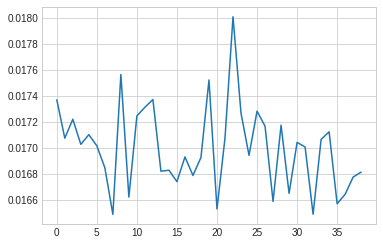

In [453]:
plt.plot(results);

# Smooth Sensitivity DP-SGD

In [564]:
def vgradient_per_ex(theta_in, x_in, y_in):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients

def smooth_dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    upper = 10
    lower = -10
    m = 4
    #t = 80
    
    BATCH_SIZE = 256
    lhs_indices, rhs_indices = build_indices(BATCH_SIZE, m, 3)
    
    #rho_weight = rho_i / X_train.shape[1]
    #print('target per-weight rho:', rho_weight)
    #target_eps_weight = np.sqrt(2*rho)
    #sigma = opt_sigma(target_eps_weight, t)
    #s = np.exp(-(3/2) * sigma**2) * (target_eps_weight - (t / sigma))

    alpha = 100
    t = .001
    assert 1/(1-np.exp(-t)) > alpha
    #gamma = alpha*(np.exp(t) - 1) + 1
    #print('gamma:', gamma)
    epsilon = rho
    epsilon_epoch = epsilon / epochs
    epsilon_iter = epsilon_epoch / X_train.shape[1]
    print('epsilon per weight:', epsilon_iter)

    def compute_eps(sens, alpha, t, sigma_sq):
        alpha_upper_bound = 1/(1-np.exp(-t))
        if alpha >= alpha_upper_bound:
            raise RuntimeError('alpha too high!!! t:', t, 'alpha:', alpha, 'req alpha <', 1/(1-np.exp(-t)))
        gamma = 1 - alpha*(1-np.exp(-t))
        return alpha * ((sens**2 / (2*gamma*sigma_sq)) + (t**2 / (4*gamma**2)))

    def compute_sigma_sq(sens):
        gamma = 1 - alpha*(1-np.exp(-t))
        #print('gamma:', gamma)

        top = (alpha * (sens**2))
        bottom_lhs = (2 * gamma * epsilon_iter)
        bottom_rhs = ((alpha * t**2) / (2 * gamma))
        #print('bottom lhs:', bottom_lhs)
        #print('bottom rhs:', bottom_rhs)
        return (top / (bottom_lhs - bottom_rhs))

    def spec_trimmed_mean(xs):
        return trimmed_mean(xs, t, m, lower, upper, lhs_indices, rhs_indices, compute_sigma_sq)
    
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)
    
    #spec_trimmed_mean = lambda xs: trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, sigma, s)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            gradients       = vgradient_per_ex(theta, xs, ys)
            noisy_avg_grad  = np.apply_along_axis(spec_trimmed_mean, 0, gradients)
            theta           = theta - noisy_avg_grad

    return theta

In [565]:
def opt_exp(eps, t, sigma):
    return 5 * (eps / t) * sigma**3 - 5 * sigma**2 - 1

def opt_sigma(target_eps, t):
    sigma_lower = t / target_eps
    sigma_upper = max(2*t / target_eps, 1/2)
    
    loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))
    while np.abs(loss) > 0.001:
        #print('loss:', loss)
        if loss < 0:
            sigma_lower = np.mean([sigma_lower, sigma_upper])
        else:
            sigma_upper = np.mean([sigma_lower, sigma_upper])

        loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))

    return np.mean([sigma_lower, sigma_upper])

def trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, compute_sigma_sq):
    n = len(xs)
    sens = compute_sens(xs, t, n, m, a, b, lhs_indices, rhs_indices)
    #print('sens:', sens)
    sigma_sq = compute_sigma_sq(sens)
    #print('sigma_sq:', sigma_sq)
    #print(sigma_sq)
    return np.mean(xs) + np.random.normal(loc=0, scale=np.sqrt(sigma_sq))
    
    #rho = (t**2/sigma**2) + (np.exp(3*sigma**2)*s**2)
    #print('actual rho:', rho)
    #print('noise scale:', (sens / s))
    return np.mean(xs)

In [568]:
accuracy(smooth_dp_gradient_descent(1, .6))

epsilon per weight: 0.005769230769230769


0.7984298982750995

In [569]:
get_eps(0.6, 100, 1e-5)

Total epsilon = 0.7162921764138407, delta = 1e-05


0.7162921764138407

# Ours Experiments

In [375]:
our_means = means[3:]
our_stds = stds[3:]

In [370]:
epsilons = [0.001, 0.0001, 0.00001]
our_means = []
our_stds = []
for epsilon in epsilons:
    accs = [accuracy(smooth_dp_gradient_descent(5, epsilon)) for _ in range(10)]
    our_means.append(np.mean(accs))
    our_stds.append(np.std(accs))    

gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.923076923076923e-06
gamma: 14899790.935208641
epsilon per weight: 1.9230769230769231e-07
gamma: 14899790.935208641
epsilon per weight: 1.9230769230769231e-07
gamma: 14899790.935208641
epsilon per weight: 1.9230769230769231e-07
gamma: 14899790.935208641
epsilon per weight: 1.9230769230769231e-07
gamma: 14899790.935208641
epsilon per weight

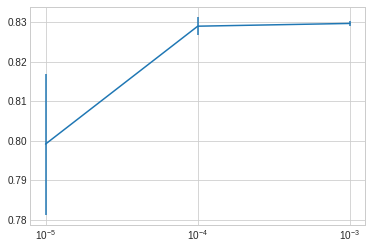

In [376]:
plt.errorbar(epsilons, our_means, yerr=our_stds)
plt.xscale('log')

# Experiments Baseline

In [377]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7593874391862008
std: 0.014221749113283489


In [380]:
rhos = [0.1, 0.01, 0.001, 0.0001]
baseline_epsilons = [zcdp_eps(rho, 1e-5) for rho in rhos]
baseline_means = []
baseline_stds = []
for rho in rhos:
    accs = [accuracy(dp_gradient_descent(5, rho)) for _ in range(10)]
    baseline_means.append(np.mean(accs))
    baseline_stds.append(np.std(accs))  


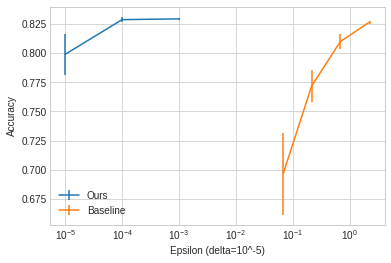

In [383]:
plt.errorbar(epsilons, our_means, yerr=our_stds, label='Ours')
plt.errorbar(baseline_epsilons, baseline_means, yerr=baseline_stds, label='Baseline')
plt.xscale('log')
plt.xlabel('Epsilon (delta=10^-5)')
plt.ylabel('Accuracy')
plt.legend()

In [570]:
[(eps, acc) for eps, acc in zip(baseline_epsilons, baseline_means)]

[(2.2459660262893473, 0.8268686421937197),
 (0.6886140424415113, 0.8101282618310481),
 (0.21559660262893474, 0.7718819106590005),
 (0.06796140424415112, 0.69640645731977)]

# Laplace Log Normal

In [169]:
def one_lln(sigma):
    x = np.random.laplace()
    y = np.random.normal()
    return x * np.exp(sigma * y)

In [122]:
def lln(size):
    sigma = 1
    x = np.random.laplace(size=size)
    y = np.random.normal(size=size)
    return x * np.exp(sigma * y)

In [130]:
np.mean(lln(500000))

0.0014440309611455206